In [2]:

from torchvision import transforms, datasets
from torchvision.transforms import Normalize, ToTensor
import os
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import ssl
import torchmetrics
from torchinfo import summary
from torchsummary import summary as testValid
import time
import io
from torch.optim import Adam, RMSprop, sgd
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from matplotlib import pyplot as plt
import numpy as np
import random
import re, string
from english_words import get_english_words_set
ssl._create_default_https_context = ssl._create_unverified_context
with open('models.txt','r') as file:
    HIGHEST_TEST_ACC = float(file.readline())
EPOCHS = 10
INIT_LR = 1e-3
BATCH_SIZE = 100
TRAIN_SPLIT = 0.8
VAL_SPLIT = 1 - TRAIN_SPLIT
import copy
import pkg_resources
from symspellpy import SymSpell, Verbosity
web2lowerset = get_english_words_set(['web2'], lower=True)
gcidelowerset = get_english_words_set(['gcide'], lower=True)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")

sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=10)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)



True

In [3]:
def seed_everything(seed=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  
seed_everything()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use gpu if available
mnist_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=0.15, std=0.3)])
train_val_data = datasets.EMNIST(
    root = 'CNN_Datasets',
    train = True,                         
    transform = mnist_transforms, 
    download = True,
    split='balanced'            
)
test_data = datasets.EMNIST(
    root = 'CNN_Datasets', 
    train = False, 
    transform = mnist_transforms,
    download = True,
    split='balanced'
)

In [5]:
import torch
train_val_data = [item for item in train_val_data if item[1] < 36]
test_data = [item for item in test_data if item[1] < 36]
train_data, val_data = torch.utils.data.random_split(dataset=train_val_data, lengths=[TRAIN_SPLIT, VAL_SPLIT])



In [6]:

from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True, 
                                          num_workers=1),
    'val' : torch.utils.data.DataLoader(val_data, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True, 
                                          num_workers=1),    
    'utility'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=1, 
                                          shuffle=False, 
                                          num_workers=1),
}

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding='same'),
            nn.MaxPool2d(2),
            nn.LeakyReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2),
            nn.LeakyReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3),
            nn.Dropout2d(p=0.25),
            nn.MaxPool2d(2),
            nn.LeakyReLU()
        )
        # self.flatten = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(2x9216 , 1024),
        #     nn.LeakyReLU(),
        #     nn.Dropout(p=0.5)
        # )
        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.25)
        )
        self.label = nn.Sequential(
            nn.Linear(512, 47),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):

        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        # x = self.deep(x)
        x = self.label(x)

        return x

In [9]:
# loop over our epochs
def train(model, opt, lossFn):
	# best_validation = 0
	for epoch in range(0, EPOCHS):
		model.train().to(device)
		# set the model in training mode
		# initialize the total training and validation loss
		train_loss = 0.0
		# initialize the number of correct predictions in the training
		# and validation step
		# loop over the training set
		train_pbar = tqdm(loaders['train'], total=len(train_data)//BATCH_SIZE)
		for index,(x,y) in enumerate(train_pbar,start=1):
			# send the input to the device
			x, y = x.to(device), y.to(device)
			# perform a forward pass and calculate the training loss
			opt.zero_grad()
			pred = model(x).to(device)
			# zero out the gradients, perform the backpropagation step,
			# and update the weights

			loss = lossFn(pred, y).to(device)
			loss.backward()
			opt.step()
			train_loss += loss.item()
			train_pbar.set_description(f"Epoch {epoch}, loss: {train_loss / index:.4f}")
		# switch off autograd for evaluation
		model.eval().to(device)
		correct, loss_sum = 0, 0
		valLength = len(val_data)//BATCH_SIZE
		val_pbar = tqdm(loaders['val'], total=valLength)
		with torch.no_grad():
			for index,(x,y) in enumerate(val_pbar,start=1):
				x, y = x.to(device), y.to(device)
				
				pred = model(x).to(device)
				loss = lossFn(pred, y).to(device)
				loss_sum += loss.item() / y.size(0)
				preds = pred.data.max(1, keepdim=True)[1].to(device)
				correct += preds.eq(y.data.view_as(preds).to(device)).sum() / y.size(0)
				val_pbar.set_description(f"val_loss: {loss_sum / index:.4f}, val_accuracy: {correct / index:.4f}")
			# if(correct/valLength > best_validation):
			# 	torch.save(model.state_dict(), 'training-model-parameters.pt')
			# 	best_validation = correct/len(val_data)//BATCH_SIZE
    
	

In [10]:
def test(model, lossFn):
	model.eval().to(device)
	test_correct, test_loss_sum = 0, 0
	test_pbar = tqdm(loaders['test'], total=len(test_data)//BATCH_SIZE)
	with torch.no_grad():
		for index,(x,y) in enumerate(test_pbar,start=1):
			x, y = x.to(device), y.to(device)
			
			pred = model(x).to(device)
			loss = lossFn(pred, y).to(device)
			test_loss_sum += loss.item() / y.size(0)
			preds = pred.data.max(1, keepdim=True)[1].to(device)
			test_correct += preds.eq(y.data.view_as(preds)).sum() / y.size(0)
			test_pbar.set_description(f"test_accuracy: {test_correct / index:.4f}")
	test_acc = test_correct.item()/len(test_pbar)
	if(test_acc > HIGHEST_TEST_ACC):
		with io.open('models.txt', 'w', encoding='utf-8') as file:
			file.write(str(test_acc))
			file.write('\n')
			model_stats = summary(model, input_size=(BATCH_SIZE,1, 28, 28), device=device, verbose=2)
			file.write(str(model_stats))
# print(f"Epoch: {epoch}| Train loss: {train_loss / train_iter: .4f}| Train acc: {train_acc / train_iter: .4f}| Val loss: {loss_sum/val_iter: .5f}| Val acc: {correct/val_iter: .4f}")
# generate a classification report

In [11]:
# initialize the LeNet model
model = Net()
model = model.to(device)
testValid(model, (1, 28, 28), BATCH_SIZE ,device=str(device))

# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
# initialize a dictionary to store training history
# nn.CrossEntropyLoss()
# nn.L1Loss(), nn.PoissonNLLLoss(), nn.HingeEmbeddingLoss(), nn.HuberLoss(), nn.SmoothL1Loss(), nn.SoftMarginLoss(), nn.MultiLabelSoftMarginLoss(),
# nn.MSELoss(), nn.BCELoss(), nn.BCEWithLogitsLoss(), nn.MultiLabelMarginLoss(),
# nn.CTCLoss(), nn.GaussianNLLLoss(), nn.MarginRankingLoss(), nn.CosineEmbeddingLoss(),
# nn.KLDivLoss(), nn.TripletMarginLoss(), nn.TripletMarginWithDistanceLoss()

lossFn = nn.CrossEntropyLoss()
# measure how long training is going to take

print("[INFO] training the network...")
startTime = time.time()
train(model,opt,lossFn)
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))
print("[INFO] evaluating network...")
test(model,lossFn)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [100, 64, 28, 28]             640
         MaxPool2d-2          [100, 64, 14, 14]               0
         LeakyReLU-3          [100, 64, 14, 14]               0
            Conv2d-4         [100, 256, 12, 12]         147,712
         Dropout2d-5         [100, 256, 12, 12]               0
         MaxPool2d-6           [100, 256, 6, 6]               0
         LeakyReLU-7           [100, 256, 6, 6]               0
            Conv2d-8           [100, 512, 4, 4]       1,180,160
         Dropout2d-9           [100, 512, 4, 4]               0
        MaxPool2d-10           [100, 512, 2, 2]               0
        LeakyReLU-11           [100, 512, 2, 2]               0
          Flatten-12                [100, 2048]               0
           Linear-13                 [100, 512]       1,049,088
        LeakyReLU-14                 [1

Epoch 0, loss: 0.5619: : 692it [00:43, 15.75it/s]                       
val_loss: 0.0028, val_accuracy: 0.8988: : 173it [00:19,  8.91it/s]                       
Epoch 1, loss: 0.2899: : 692it [00:32, 21.48it/s]                       
val_loss: 0.0026, val_accuracy: 0.9053: : 173it [00:20,  8.50it/s]                       
Epoch 2, loss: 0.2491: : 692it [00:30, 22.46it/s]                       
val_loss: 0.0024, val_accuracy: 0.9126: : 173it [00:20,  8.58it/s]                       
Epoch 3, loss: 0.2280: : 692it [00:30, 22.51it/s]                       
val_loss: 0.0023, val_accuracy: 0.9156: : 173it [00:22,  7.84it/s]                       
Epoch 4, loss: 0.2140: : 692it [00:31, 22.23it/s]                       
val_loss: 0.0023, val_accuracy: 0.9160: : 173it [00:17, 10.08it/s]                       
Epoch 5, loss: 0.1995: : 692it [00:28, 24.06it/s]                       
val_loss: 0.0024, val_accuracy: 0.9133: : 173it [00:19,  8.85it/s]                       
Epoch 6, loss: 0.1851:

[INFO] total time taken to train the model: 509.48s
[INFO] evaluating network...


test_accuracy: 0.9189: 100%|██████████| 144/144 [00:10<00:00, 13.46it/s]


In [12]:
def emnist_to_dictionary():
    label_dictionary = {}
    for x,y in loaders['utility']:
        if int(y) in label_dictionary:
            label_dictionary[int(y)].append(x)
        else:
            label_dictionary[int(y)] = [x]
    return label_dictionary

def load_string_emnist_mappings():
    with open("EMNIST_Datasets/emnist-balanced-mapping.txt") as f:
        emnist_mapping = {}
        for line in f.readlines():
            data = line.strip().split(' ')
            emnist_mapping[int(data[1])] = int(data[0])
        return emnist_mapping
    
def load_emnist_string_mappings():
    with open("EMNIST_Datasets/emnist-balanced-mapping.txt") as f:
        emnist_mapping = {}
        for line in f.readlines():
            data = line.strip().split(' ')
            emnist_mapping[int(data[0])] = int(data[1])
        return emnist_mapping

In [13]:
emnist_dictionary = emnist_to_dictionary()
string_emnist_mappings = load_string_emnist_mappings()
emnist_string_mappings = load_emnist_string_mappings()

In [14]:
def cleanString(message):
    # .,-(:)";/[]$&%+?=!#{}\
    pattern = re.compile('[^A-Za-z0-9\s\']+', re.UNICODE)
    cleaned_message = pattern.sub('', message)
    return cleaned_message.strip().lower()


def convertToEMNIST(message):
    message_conversion = []
    for word in message.split(' '):
        for char in word:
            if char.isalnum():
                if ord(char) in string_emnist_mappings:
                    emnist_index = string_emnist_mappings[ord(char)]
                else:
                    emnist_index = string_emnist_mappings[ord(char.swapcase())]
                image_list = emnist_dictionary[emnist_index]
                image_pick = random.randint(0,len(image_list)-1)
                message_conversion.append(image_list[image_pick])
            else: 
                message_conversion.append(char)
        message_conversion.append(' ')
    return message_conversion
        

def predict(emnist_message, model):
    predicted_message = []
    model.eval().to(device)
    test_pbar = tqdm(emnist_message, total=len(emnist_message))
    with torch.no_grad():
        for x in test_pbar:
            if not isinstance(x, str):
                x = x.reshape(1,1,28,28).to(device)
                
                preds = model(x).to(device)
                probs = torch.softmax(preds, dim=1).to(device)
                
                # Get top 3 probabilities                
                top_probs, top_indices = torch.topk(probs, k=10, dim=1)   
                mask = top_probs >= 0.01
                top_probs = top_probs[mask]
                top_indices = top_indices[mask]     
                top_probs = torch.round(top_probs * 100) / 100
                predicted_message.append(zip(top_indices,top_probs))
            else:
                predicted_message.append(x)
    return predicted_message

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jaydo\AppData\Local\Temp\ipykernel_17572\3651720052.py:3: SyntaxWarning: invalid escape sequence '\s'
  pattern = re.compile('[^A-Za-z0-9\s\']+', re.UNICODE)


In [15]:


def checkExistence(wordList):
    validWordList = []
    mostlyValidWordList = []
    somewhatValidWordList = []
            
    for word in wordList:
        if len(sym_spell.lookup(word, Verbosity.ALL, max_edit_distance=0)) > 0:
            somewhatValidWordList.append(word)
        if word in web2lowerset:
            if word in somewhatValidWordList:
                somewhatValidWordList.pop()
                mostlyValidWordList.append(word)
            else:
                somewhatValidWordList.append(word)
        if word in gcidelowerset:
            if word in mostlyValidWordList:
                mostlyValidWordList.pop()
                validWordList.append(word)
            if word in somewhatValidWordList:
                somewhatValidWordList.pop()
                mostlyValidWordList.append(word)
            else:
                somewhatValidWordList.append(word)

    if len(validWordList) > 0:
        return validWordList, False
    elif len(mostlyValidWordList) > 0:
        return mostlyValidWordList, False
    elif len(somewhatValidWordList) > 0:
        return somewhatValidWordList, False
    else:
        return wordList, True
    
def spellCorrection(real_words_list, distance):
    for possible_word in real_words_list:
        candidates = sym_spell.lookup(possible_word, Verbosity.ALL, max_edit_distance=distance)
        if candidates is not None:
            for candidate in candidates:
                if len(candidate.term) == len(real_words_list[0]):
                    return candidate.term
    return None    

def add_probable_characters(possible_chars, wordList, contains_numbers, minimum_viable_probability):
    top_indices, top_probs = zip(*possible_chars)
    newWordList = []
    temp_contains_numbers = False
    somethingAppended = False
    valid_characters = []
    for index in range(0,len(top_indices)):
        if top_probs[index] > minimum_viable_probability:
            if int(top_indices[index]) < 10:
                if contains_numbers:
                    temp_contains_numbers = True
                    somethingAppended = True
                    valid_characters.append(chr(emnist_string_mappings[int(top_indices[index])]))
            else:
                valid_characters.append(chr(emnist_string_mappings[int(top_indices[index])]))
                somethingAppended = True
        elif not somethingAppended:
            if int(top_indices[index]) < 10:
                if contains_numbers:
                    temp_contains_numbers = True
                    somethingAppended = True
                    valid_characters.append(chr(emnist_string_mappings[int(top_indices[index])]))
            else:
                valid_characters.append(chr(emnist_string_mappings[int(top_indices[index])]))
                somethingAppended = True
                
    if not somethingAppended:
        somethingAppended = True
        valid_characters.append(chr(emnist_string_mappings[int(top_indices[0])]))
            
    for word in wordList:
        for char in valid_characters:
            newWordList.append(word + char)
            
    return newWordList, temp_contains_numbers

def convertToString(message, mode, minimum_viable_probability):

    final_string = ""
    wordList = [""]
    contains_numbers = True
    for char in message:
        if not isinstance(char, str):
            wordList, contains_numbers = add_probable_characters(char, wordList, contains_numbers, minimum_viable_probability)
        
        elif char == '\'':
            final_string += char
            contains_numbers = True
            
        elif len(wordList[0]) > 0:
            processing = True
            real_words_list = []
            if contains_numbers:
                for word in wordList:
                    if(all(char.isdigit() for char in word)):
                        final_string += word
                        processing = False
                        break
            if processing:
                filterNumbers = []
                for word in wordList:
                    if all(char.isalpha() for char in word):
                        filterNumbers.append(word.lower()) 
                real_words_list = filterNumbers
            if mode > 1:             
                if processing:
                    real_words_list, processing = checkExistence(real_words_list)
                    if not processing:
                        final_string += real_words_list[0]
                                
                if mode > 2:             
                    if processing:
                        correction = spellCorrection(real_words_list, 1)    
                        if correction is not None:
                            final_string += correction
                            processing = False
                            
                    if mode > 3:                 
                        if processing and len(wordList[0]) > 6:            
                            correction = spellCorrection(real_words_list, 2)    
                            if correction is not None:
                                final_string += correction
                                processing = False
                                
                        if mode > 4: 
                            if processing and len(wordList[0]) > 12:            
                                correction = spellCorrection(real_words_list, 3)    
                                if correction is not None:
                                    final_string += correction
                                    processing = False
                
            if processing:
                if len(real_words_list) > 0:
                    final_string += real_words_list[0]
                else:
                    final_string += wordList[0]
                processing = False
                
            final_string += char
            contains_numbers = True
            wordList = [""]
            
        else:
            final_string += char
            contains_numbers = True
            wordList = [""]
            
    return final_string

def readMessage(prediction, mode, minimum_viable_probability):
    if mode == 0:
        final_string = ""
        for char in prediction:
            if not isinstance(char, str):
                top_indices, _ = zip(*char)
                final_string += chr(emnist_string_mappings[int(top_indices[0])])
            else:
                final_string += char
        return final_string
    else:
        return convertToString(prediction, mode, minimum_viable_probability).strip()



In [29]:
random.seed(5325)
with open('paragraphs.txt/paragraphs.txt') as paragraphs:
    total_predictions = 0
    probability_dict = {0.2:[], 0.1:[], 0.05:[], 0.025:[], 0.01:[]}
    code_dict = {0:copy.deepcopy(probability_dict), 1:copy.deepcopy(probability_dict), 2:copy.deepcopy(probability_dict), 3:copy.deepcopy(probability_dict), 4:copy.deepcopy(probability_dict), 5:copy.deepcopy(probability_dict)}
    metrics_100_predictions = {"word_accuracy": copy.deepcopy(code_dict), "char_accuracy": copy.deepcopy(code_dict), "time":copy.deepcopy(code_dict),"prediction_time":[]}
    for start, line in enumerate(paragraphs.readlines(), start = 0):
        if start % 300 == 0:
            line = cleanString(line)
            emnist_conversion = convertToEMNIST(line.upper())
            prediction_time = time.time_ns() // 1000000        
            prediction = predict(emnist_conversion, model)
            prediction_time = time.time_ns() // 1000000 - start
            metrics_100_predictions["prediction_time"].append(prediction_time)
            total_predictions += 1
            for code in (0, 1, 2, 3, 4, 5):
                for minimum_viable_probability in (0.2, 0.1, 0.05, 0.025):
                    start = time.time_ns() // 1000000
                    translation = readMessage(copy.deepcopy(prediction), code, minimum_viable_probability).strip()
                    end = time.time_ns() // 1000000
                    metrics_100_predictions["time"][code][minimum_viable_probability].append(end-start)
                    direct_correct = 0
                    for iter in range(len(line)):
                        originalLine = line[iter].lower()
                        if line[iter].isalnum():
                            if originalLine == translation[iter].lower() :
                                direct_correct += 1
                    
                    metrics_100_predictions["char_accuracy"][code][minimum_viable_probability].append(direct_correct/len(line))
                    direct_correct = 0
                    translation_compare = translation.split(" ")
                    word_compare =  line.split(" ")
                    for iter in range(len(word_compare)):
                        if word_compare[iter].lower() == translation_compare[iter].lower():
                            direct_correct += 1

                    metrics_100_predictions["word_accuracy"][code][minimum_viable_probability].append(direct_correct/len(word_compare))
            if total_predictions > 40:
                break

100%|██████████| 245/245 [00:00<00:00, 545.91it/s]


c:\Users\jaydo\OneDrive\Documents\CS\Spring24CS4824\SemesterProject\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jaydo\OneDrive\Documents\CS\Spring24CS4824\SemesterProject\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


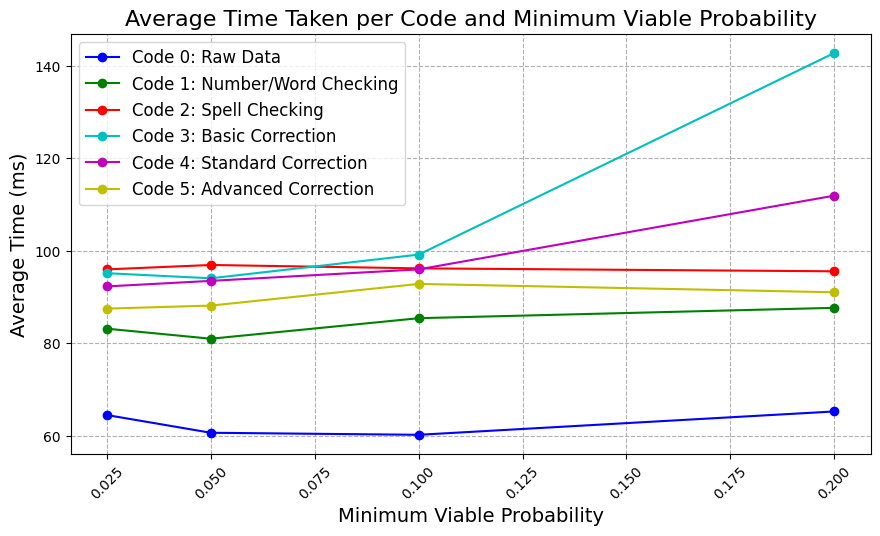

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize colors for each code
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Initialize a list to store average times for each code
average_times_per_code = []

# Initialize a list to store probabilities
probabilities = [0.2, 0.1, 0.05, 0.025, 0.01]

# Iterate over each code
for code in range(6):
    # Initialize a list to store average times for the current code
    average_times = []

    # Iterate over each minimum_viable_probability
    for minimum_viable_probability in probabilities:
        # Extract time data for the current code and minimum_viable_probability
        time_data = metrics_100_predictions["time"][code][minimum_viable_probability]

        # Calculate the average time
        average_time = np.mean(time_data)

        # Append average time to the list
        average_times.append(average_time)

    # Append average times for the current code to the list
    average_times_per_code.append(average_times)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the average times for each code
for code, color in zip(("0: Raw Data", "1: Number/Word Checking", "2: Spell Checking", "3: Basic Correction", "4: Standard Correction", "5: Advanced Correction"), colors):
    ax.plot(probabilities, average_times_per_code[int(code[0])], color=color, marker='o', linestyle='-', label=f'Code {code}')

# Set the x-axis and y-axis labels
ax.set_xlabel('Minimum Viable Probability', fontsize=14)
ax.set_ylabel('Average Time (ms)', fontsize=14)

# Set the title
ax.set_title('Average Time Taken per Code and Minimum Viable Probability', fontsize=16)

# Add a legend
ax.legend(fontsize=12, loc='upper left')

# Add grid lines
ax.grid(True, linestyle='--')

# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize colors for each code
colors = ['b', 'g', 'r', 'c', 'm','y']

# Initialize a list to store average times for each code
average_times_per_code = []

# Initialize a list to store probabilities
probabilities = [0.2, 0.1, 0.05, 0.025, 0.01]

# Iterate over each code
for code in range(6):
    # Initialize a list to store average times for the current code
    average_times = []

    # Iterate over each minimum_viable_probability
    for minimum_viable_probability in probabilities:
        # Extract time data for the current code and minimum_viable_probability
        time_data = metrics_100_predictions["char_accuracy"][code][minimum_viable_probability]

        # Calculate the average time
        average_time = np.mean(time_data)

        # Append average time to the list
        average_times.append(average_time)

    # Append average times for the current code to the list
    average_times_per_code.append(average_times)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the average times for each code
for code, color in zip(("0: Raw Data", "1: Number/Word Checking", "2: Spell Checking", "3: Basic Correction", "4: Standard Correction", "5: Advanced Correction"), colors):
    ax.plot(probabilities, average_times_per_code[int(code[0])], color=color, marker='o', linestyle='-', label=f'Code {code}')

# Set the x-axis and y-axis labels
ax.set_xlabel('Minimum Viable Probability', fontsize=14)
ax.set_ylabel('Character Accuracy', fontsize=14)

# Set the title
ax.set_title('Character Accuracy per Code and Minimum Viable Probability', fontsize=16)

# Add a legend
ax.legend(fontsize=12)

# Add grid lines
ax.grid(True, linestyle='--')

# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

NameError: name 'metrics_100_predictions' is not defined

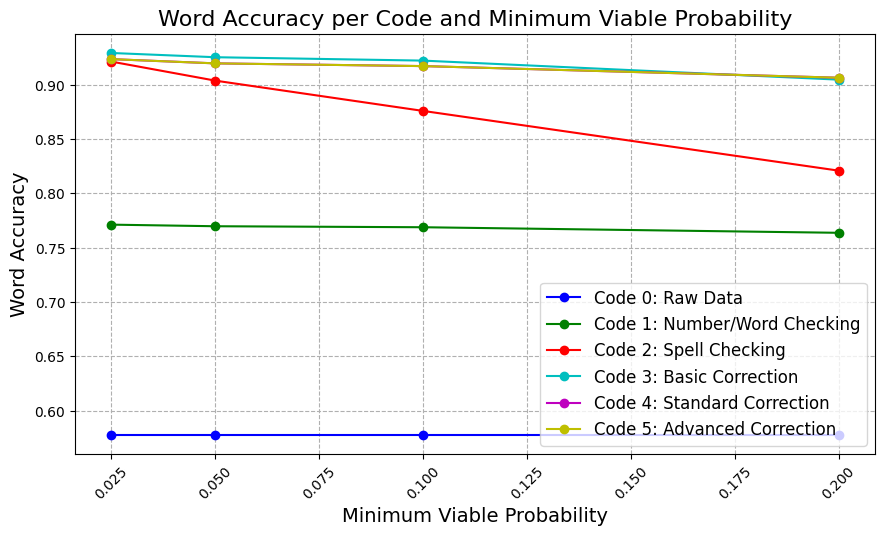

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize colors for each code
colors = ['b', 'g', 'r', 'c', 'm','y']

# Initialize a list to store average times for each code
average_times_per_code = []

# Initialize a list to store probabilities
probabilities = [0.2, 0.1, 0.05, 0.025, 0.01]

# Iterate over each code
for code in range(6):
    # Initialize a list to store average times for the current code
    average_times = []

    # Iterate over each minimum_viable_probability
    for minimum_viable_probability in probabilities:
        # Extract time data for the current code and minimum_viable_probability
        time_data = metrics_100_predictions["word_accuracy"][code][minimum_viable_probability]

        # Calculate the average time
        average_time = np.mean(time_data)

        # Append average time to the list
        average_times.append(average_time)

    # Append average times for the current code to the list
    average_times_per_code.append(average_times)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the average times for each code
for code, color in zip(("0: Raw Data", "1: Number/Word Checking", "2: Spell Checking", "3: Basic Correction", "4: Standard Correction", "5: Advanced Correction"), colors):
    ax.plot(probabilities, average_times_per_code[int(code[0])], color=color, marker='o', linestyle='-', label=f'Code {code}')

# Set the x-axis and y-axis labels
ax.set_xlabel('Minimum Viable Probability', fontsize=14)
ax.set_ylabel('Word Accuracy', fontsize=14)

# Set the title
ax.set_title('Word Accuracy per Code and Minimum Viable Probability', fontsize=16)

# Add a legend
ax.legend(fontsize=12)

# Add grid lines
ax.grid(True, linestyle='--')

# Adjust the spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [20]:
import numpy as np

# Initialize colors for each code
colors = ['b', 'g', 'r', 'c', 'm']

# Number of iterations
num_iterations = len(metrics_10_predictions["time"][0][0.5])  # Assuming 0.5 probability has all iterations, can be replaced with any other probability

# Initialize a list to store average times for each code
average_times_per_code = []

# Iterate over each code
for code in range(5):
    # Initialize a list to store average times for the current code
    average_times = []
    # Iterate over each iteration
    for iteration in range(num_iterations):
        # Initialize a list to store times for the current iteration
        times_per_iteration = []
        # Iterate over each minimum_viable_probability and collect times
        for minimum_viable_probability in (0.5, 0.33, 0.25, 0.2, 0.1, 0.05, 0.025, 0.01):
            # Extract time data for the current code, iteration, and minimum_viable_probability
            time_data = metrics_10_predictions["time"][code][minimum_viable_probability][iteration]
            # Append time to the list
            times_per_iteration.append(time_data)
        # Calculate the average time for the current iteration
        average_time = np.mean(times_per_iteration)
        # Append average time to the list
        average_times.append(average_time)
    # Append average times for the current code to the list
    average_times_per_code.append(average_times)

# Plot the average times for each code
for code, color in zip(range(5), colors):
    plt.plot(range(1, num_iterations + 1), average_times_per_code[code], color=color, label=f'Code {code}')

# Add labels and legend
plt.xlabel('Iterations')
plt.ylabel('Average Time (ms)')
plt.title('Average Time Taken per Code over Iterations')
plt.legend()
plt.show()

NameError: name 'metrics_10_predictions' is not defined